<a href="https://colab.research.google.com/github/cleonorris02/COMP-551/blob/Assignment-1/comp551_assignment1_group_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dataset 1: National Health and Nutrition Health Survey**



# Task 1: Acquire, preprocess, and analyze the data

Below is the work to preprocess and analyze the data. Methods include checking for null values, obtaining the basic statistics of the input feature dataset, and encoding categorical variables.

In [ ]:
!pip install ucimlrepo

In [ ]:
import numpy as np
import time
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from ucimlrepo import fetch_ucirepo
np.random.seed(1234)
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats

In [ ]:
# fetch dataset 1: NHANES age prediction.csv (National Health and Nutrition Health Survey 2013-2014 (NHANES) Age Prediction Subset)
ds_1 = fetch_ucirepo(id=887)

print('Data Table:\n')
data = ds_1['data']['original']

x = data.iloc[:, 3:].values
# target values are currently strings, change them into integers
y = data['age_group'].factorize()[0]

data.head()

Data Table:



,SEQN,age_group,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
0,73564.0,Adult,61.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
1,73568.0,Adult,26.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85
2,73576.0,Adult,16.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14
3,73577.0,Adult,32.0,1.0,2.0,28.9,104.0,2.0,84.0,16.15
4,73580.0,Adult,38.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92


In [ ]:
# check for null values
print(f'There are {data.isnull().any(axis=1).sum()} rows with missing values.')

There are 0 rows with missing values.


In [ ]:
data.describe()

,SEQN,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
count,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000
mean,78691.853819,41.795874,1.511414,1.822651,27.955180,99.553117,2.016242,114.978929,11.834794
std,2921.365151,20.156111,0.499979,0.398918,7.248962,17.889834,0.185556,47.061239,9.718812
min,73564.000000,12.000000,1.000000,1.000000,14.500000,63.000000,1.000000,40.000000,0.140000
25%,76171.750000,24.000000,1.000000,2.000000,22.800000,91.000000,2.000000,87.000000,5.860000
50%,78749.000000,41.000000,2.000000,2.000000,26.800000,97.000000,2.000000,105.000000,9.040000
75%,81213.500000,58.000000,2.000000,2.000000,31.200000,104.000000,2.000000,130.000000,14.440000
max,83727.000000,80.000000,2.000000,7.000000,70.100000,405.000000,3.000000,604.000000,102.290000


In [ ]:
# print the feature shape and classes of dataset
(N,D), C = x.shape, np.unique(y).size
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

np.random.seed(100)
# generate an indices array from 0 to N-1 and permute it
inds = np.random.permutation(N)

# split the dataset into train and test
# want 80% train and 20% to test. Given N can find index to split on:
index_split = int(N*0.8)
x_train, y_train = x[inds[:index_split]], y[inds[:index_split]]
x_test, y_test = x[inds[index_split:]], y[inds[index_split:]]

instances (N) 	 2278 
 features (D) 	 7 
 classes (C) 	 2


In [ ]:
unique_values = pd.Series(y_test).unique()
print(unique_values)

[0 1]


Move on to examining output data.

In [ ]:
# examine counts of the age group classes
data["age_group"].value_counts()

Adult     1914
Senior     364
Name: age_group, dtype: int64

In [ ]:
# compute mean of each feature for each class
group_means = data.groupby('age_group').mean()
group_means

,SEQN,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
age_group,,,,,,,,,
Adult,78668.599791,35.780564,1.512017,1.806165,27.968286,98.644723,2.014107,109.990596,12.106661
Senior,78814.129121,73.425824,1.508242,1.909341,27.886264,104.329670,2.027473,141.208791,10.405247


By computing the mean of each feature for both classes (Adult and Senior), we see that some features are relatively the same for both (e.g. PAQ605, BMXBMI, and DIQ010), while other means are different between classes (e.g. LBXGLU, LBXGLT, LBXIN).

In [ ]:
# rank the squared difference of the group means
group_diff = (group_means.iloc[0]-group_means.iloc[1])**2
group_diff.sort_values(ascending=False)

SEQN        21178.785851
RIDAGEYR     1417.165594
LBXGLT        974.575736
LBXGLU         32.318625
LBXIN           2.894810
PAQ605          0.010645
BMXBMI          0.006728
DIQ010          0.000179
RIAGENDR        0.000014
dtype: float64

By ranking the squared difference of the group means, we see that the aforementioned features that don't seem to change between classes are indeed ranked the lowest. The features whose means change the most between classes are SEQN (a sequence number, not very meaningful), RIDAGEYR (respondent's age, expected), and LBXGLT (Respondent's Oral, interesting to note).

<Axes: xlabel='RIDAGEYR', ylabel='LBXGLT'>

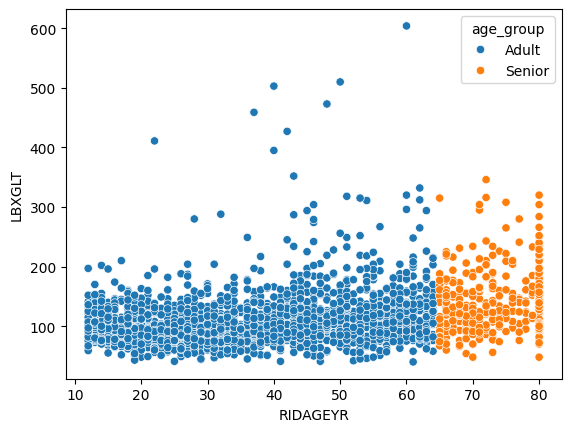

In [ ]:
# visualize this data: plot highest correlated to class (aside from the sequence number feature)
# plot age versus Respondent's Oral
sns.scatterplot(x=data['RIDAGEYR'],y=data['LBXGLT'], hue=data['age_group'])

The line separating the age group was expected, and it is interesting to note that there are more outliers for the LBXGLT feature for the Adult class than for the Senior class. We observe the same phenomenon for the LBXGLU feature below.

<Axes: xlabel='RIDAGEYR', ylabel='LBXGLU'>

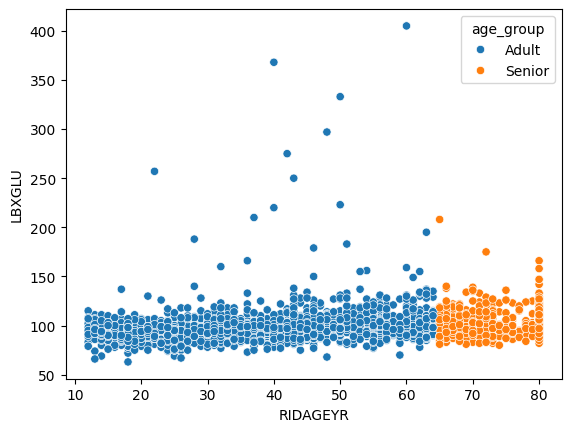

In [ ]:
# plot age versus Respondent's Blood Glucose after fasting
sns.scatterplot(x=data['RIDAGEYR'],y=data['LBXGLU'], hue=data['age_group'])

**Normalizing the data**

Data should be normalized after splitting it into training and test sets. According to DataCamp, this "is to prevent ‘data leakage’ as the normalization would give the model additional information about the test set if we normalized all the data at once".

In [ ]:
# normalize the data: scale the features using StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

We now examine the data after it has been scaled.

# Task 2: Implementing KNN and DT

**KNN**

In [ ]:
# define KNN class
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:

    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return

    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y
        self.C = np.max(y) + 1
        return self

    def predict_knn(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
        # calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
        # self.x is in shape (100, 2), x_test is in shape (50, 2)
        # self.x[None, :, :] is in shape (1, 100, 2), and x_test[:,None,:] is in shape (50, 1, 2)
        # result: (x_test.shape[0], self.x.shape[0])
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        #ith-row of knns stores the indices of k closest training samples to the ith-test sample
        knns = np.zeros((num_test, self.K), dtype=int)
        #ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            # print(i)
            knns[i,:] = np.argsort(distances[i])[:self.K]
            # print(knns[i,:])
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
        #y_prob /= np.sum(y_prob, axis=-1, keepdims=True)
        #simply divide by K to get a probability distribution
        y_prob /= self.K
        return y_prob, knns

**Decision Tree**

In [ ]:
# defining Node and Decision Tree classes, required functions for Decision Tree model

class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent
            self.num_classes = parent.num_classes           #copies the num classes from the parent
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob) #stores the class probability for the node

In [ ]:
def greedy_test(node, cost_fn):
    '''Function that takes as input the current node and cost function, and produces the lowest
    cost feature-value combination.
    '''
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            #compute the left and right cost based on the current split
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

In [ ]:
def cost_misclassification(labels):
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

# computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log2(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

# computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))

In [ ]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination
        self.root = None                #stores the root of the decision tree
        self.cost_fn = cost_fn          #stores the cost function of the decision tree
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination

    def fit(self, data, labels):
        pass

    def predict(self, data_test):
        pass

    def get_features_used(self):
        features_used = []
        self._traverse_tree(self.root, features_used)
        return features_used

    def _traverse_tree(self, node, features_used):
        #print(node, type(node))
        if node.left and node.right:
            features_used.append(node.split_feature)
            self._traverse_tree(node.left, features_used)
            self._traverse_tree(node.right, features_used)

In [ ]:
def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1
    # below are initialization of the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    # to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self

def _fit_tree(self, node):
    # this gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    # greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    # if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    # to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    # store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    # define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    # recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    # assign the left and right child to present child
    node.left = left
    node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

In [ ]:
def predict(self, data_test):
    '''
    Take as input test data, return the class probabilities of the training data under the leaf.
    '''
    # initialize class_probs vector
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    # iterate through data
    for n, x in enumerate(data_test):
        node = self.root
        # loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        # the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n,:] = node.class_prob
    return class_probs

DecisionTree.predict = predict

# Task 3: Running experiments

**Test different K values and see how it affects the training data accuracy and test data accuracy of KNN**

In [ ]:
# define a function evaluate_acc to evaluate the model accuracy
def evaluate_acc(y_test_actual, y_test_pred):
  accuracy = np.sum(y_test_pred == y_test_actual)/y_test_actual.shape[0]
  return accuracy

best K = 8, test accuracy = 0.8135964912280702


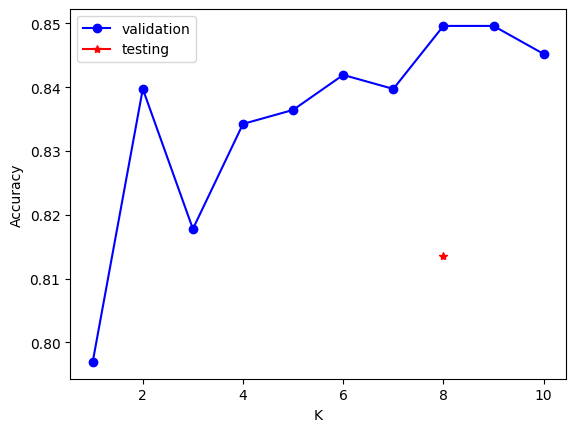

In [ ]:
# further split the training data into 50% training and 50% validation
split_num = int(0.5*x_train.shape[0])
x_train_tr, y_train_tr = x_train[:split_num], y_train[:split_num]
x_train_va, y_train_va = x_train[split_num:], y_train[split_num:]

model_choices=[]
valid_acc = []

n_valid = y_train_va.shape[0]

for k in range(1,11):
    knn = KNN(K=k) # create a KNN object (OOP)
    # y_train_va_prob,_ = knn.fit(x_train, y_train).predict(x_train_va) # wrong
    y_train_va_prob_knn,_ = knn.fit(x_train_tr, y_train_tr).predict_knn(x_train_va) # bug fixed
    y_train_va_pred_knn = np.argmax(y_train_va_prob_knn,axis=-1)
    accuracy = evaluate_acc(y_train_va ,y_train_va_pred_knn)
    model_choices.append(k)
    valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
knn = KNN(K=best_valid_K)
y_test_prob_knn,_ = knn.fit(x_train, y_train).predict_knn(x_test)
y_test_pred_knn = np.argmax(y_test_prob_knn, axis=-1)
test_accuracy_knn = evaluate_acc(y_test, y_test_pred_knn)
#test_accuracy_knn = np.sum(y_test_pred == y_test)/y_test.shape[0]
print(f'best K = {best_valid_K}, test accuracy = {test_accuracy_knn}')

# plot accuracy for each value of K tested
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy_knn, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('iris_KNN_chooseK.png',dpi=300,bbox_inches='tight')

**Test how maximum tree depth affects the performance of DT**

best depth (Misclassification cost function) = 6, test accuracy = 0.8048245614035088


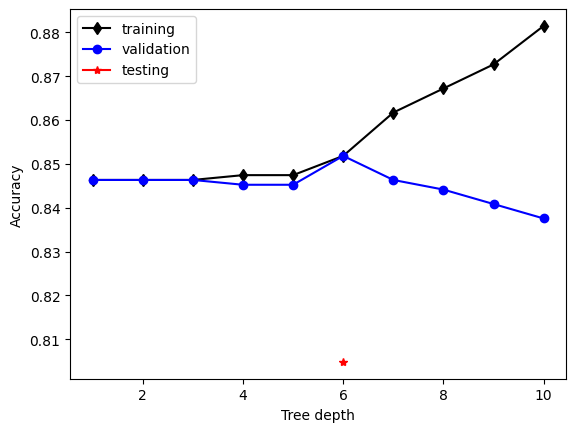

In [ ]:
model_choices=[]
train_acc = []
valid_acc = []

n_train = y_train_tr.shape[0]
n_valid = y_train_va.shape[0]

for k in range(1, 11):
  # create a DecisionTree object (OOP)
  dt = DecisionTree(max_depth=k)

  y_train_tr_prob_dt = dt.fit(x_train_tr, y_train_tr).predict(x_train_tr)
  y_train_tr_pred_dt = np.argmax(y_train_tr_prob_dt, axis=-1)
  acc_tr = evaluate_acc(y_train_tr, y_train_tr_pred_dt)

  y_train_va_prob_dt = dt.fit(x_train_tr, y_train_tr).predict(x_train_va)
  y_train_va_pred_dt = np.argmax(y_train_va_prob_dt, axis=-1)
  acc_va = evaluate_acc(y_train_va, y_train_va_pred_dt)

  model_choices.append(k)
  train_acc.append(acc_tr)
  valid_acc.append(acc_va)

# use the best K to predict test data
best_depth = model_choices[valid_acc.index(max(valid_acc))]
dt = DecisionTree(max_depth=best_depth)
y_test_prob_dt = dt.fit(x_train, y_train).predict(x_test)
y_test_pred_dt = np.argmax(y_test_prob_dt, axis=-1)
test_accuracy_dt = evaluate_acc(y_test, y_test_pred_dt)
print(f'best depth (Misclassification cost function) = {best_depth}, test accuracy = {test_accuracy_dt}')

# plot accuracy for each level of tree depth tested
plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy_dt, marker='*', color='red', label='testing')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('iris_DT_chooseDepth.png',dpi=300,bbox_inches='tight')

**Compare the accuracy and AUROC of KNN and DT algorithm**

In [ ]:
compare_models = {'Model': ['KNN', 'Decision Tree'], 'Test Accuracy (with K = 4, Max Depth = 2)': [test_accuracy_knn, test_accuracy_dt]}

pd.DataFrame(compare_models)

,Model,"Test Accuracy (with K = 4, Max Depth = 2)"
0,KNN,0.813596
1,Decision Tree,0.804825


**Plot the ROC for KNN and DT**

True/False Positive Rates for KNN

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_knn)

cm_df_knn = pd.DataFrame(cm, index=['Actual Negative','Actual Positive'],
                     columns=['Predicted Negative', 'Predicted Positive'])
print(cm_df_knn)

                 Predicted Negative  Predicted Positive
Actual Negative                 359                  12
Actual Positive                  73                  12


True/False Positive Rates for DT

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_dt)

cm_df_dt = pd.DataFrame(cm, index=['Actual Negative','Actual Positive'],
                     columns=['Predicted Negative', 'Predicted Positive'])
print(cm_df_dt)

                 Predicted Negative  Predicted Positive
Actual Negative                 366                   5
Actual Positive                  84                   1


ROC Plots

In [ ]:
y_test_prob_knn[:,1].sum()

72.125

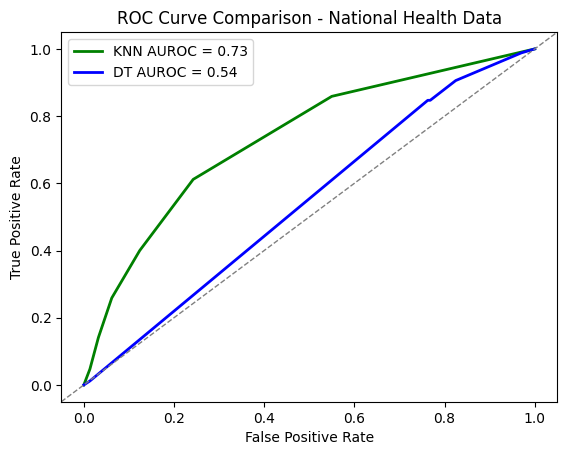

In [ ]:
# Calculating ROC curve values and AUC score
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_test_prob_knn[:, 1])
roc_auc_knn = roc_auc_score(y_test, y_test_prob_knn[:, 1])

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_test_prob_dt[:, 1])
roc_auc_dt = roc_auc_score(y_test, y_test_prob_dt[:, 1])

plt.clf()
plt.plot(fpr_knn, tpr_knn, "g-", lw=2, label="KNN AUROC = %0.2f" % roc_auc_knn)
plt.plot(fpr_dt, tpr_dt, "b-", lw=2, label="DT AUROC = %0.2f" % roc_auc_dt)
plt.axline((0, 0), (1, 1), linestyle="--", lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - National Health Data')
plt.legend(loc="best")
plt.savefig("roc_curve.png", bbox_inches='tight', dpi=300)

**Test different distance/cost functions**

Try KNN with Manhattan distance function, since we're working with continuous input features

best K (Manhattan Distance) = 6, test accuracy = 0.8092105263157895


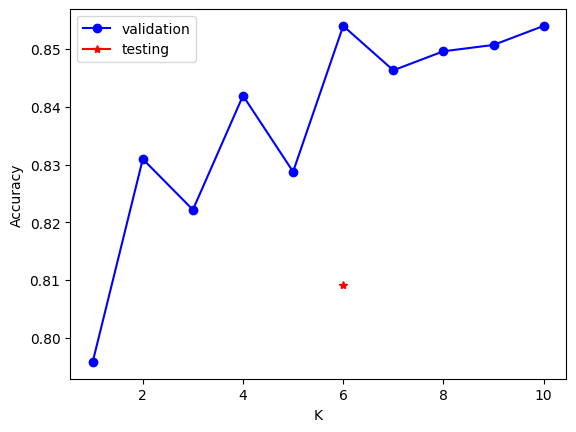

In [ ]:
split_num = int(0.5*x_train.shape[0])
x_train_tr, y_train_tr = x_train[:split_num], y_train[:split_num]
x_train_va, y_train_va = x_train[split_num:], y_train[split_num:]

model_choices=[]
valid_acc = []

n_valid = y_train_va.shape[0]

for k in range(1,11):
  # create a KNN object (OOP)
  knn = KNN(K=k, dist_fn = manhattan)
  # y_train_va_prob,_ = knn.fit(x_train, y_train).predict(x_train_va) # wrong
  y_train_va_prob,_ = knn.fit(x_train_tr, y_train_tr).predict_knn(x_train_va) # bug fixed
  y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)
  accuracy = np.sum(y_train_va_pred == y_train_va)/n_valid
  model_choices.append(k)
  valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
knn = KNN(K=best_valid_K)
y_test_prob,_ = knn.fit(x_train, y_train).predict_knn(x_test)
y_test_pred = np.argmax(y_test_prob, axis=-1)
test_accuracy_knn = np.sum(y_test_pred == y_test)/y_test.shape[0]
print(f'best K (Manhattan Distance) = {best_valid_K}, test accuracy = {test_accuracy_knn}')

# plot accuracy for each value of K tested
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy_knn, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('iris_KNN_chooseK.png',dpi=300,bbox_inches='tight')

Try Decision Tree with Entropy as cost function

best depth (Entropy cost function) = 1, test accuracy = 0.8135964912280702


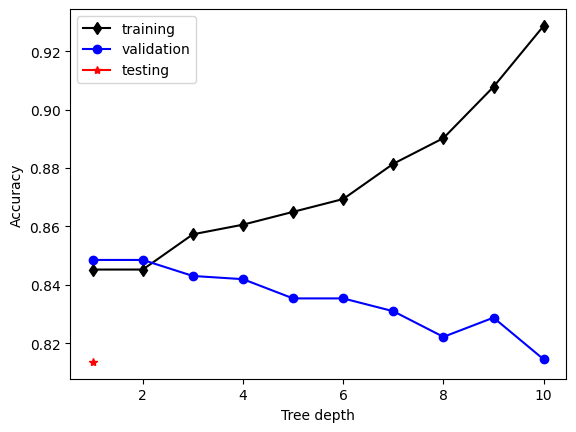

In [ ]:
model_choices=[]
train_acc = []
valid_acc = []

n_train = y_train_tr.shape[0]
n_valid = y_train_va.shape[0]

for k in range(1, 11):
    dt = DecisionTree(max_depth=k, cost_fn=cost_entropy) # create a KNN object (OOP)

    y_train_tr_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_tr)
    y_train_tr_pred = np.argmax(y_train_tr_prob, axis=-1)
    acc_tr = np.sum(y_train_tr_pred == y_train_tr)/n_train

    y_train_va_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_va)
    y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
    acc_va = np.sum(y_train_va_pred == y_train_va)/n_valid

    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)

# use the best K to predict test data
best_depth = model_choices[valid_acc.index(max(valid_acc))]
dt = DecisionTree(max_depth=best_depth)
y_test_prob = dt.fit(x_train, y_train).predict(x_test)
y_test_pred = np.argmax(y_test_prob, axis=-1)
test_accuracy_dt = np.sum(y_test_pred == y_test)/y_test.shape[0]
print(f'best depth (Entropy cost function) = {best_depth}, test accuracy = {test_accuracy_dt}')

# plot accuracy for each level of tree depth tested
plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy_dt, marker='*', color='red', label='testing')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('iris_DT_chooseDepth.png',dpi=300,bbox_inches='tight')

Try Decision Tree with Gini Index as cost function

best depth (Gini Index cost function) = 1, test accuracy = 0.8135964912280702


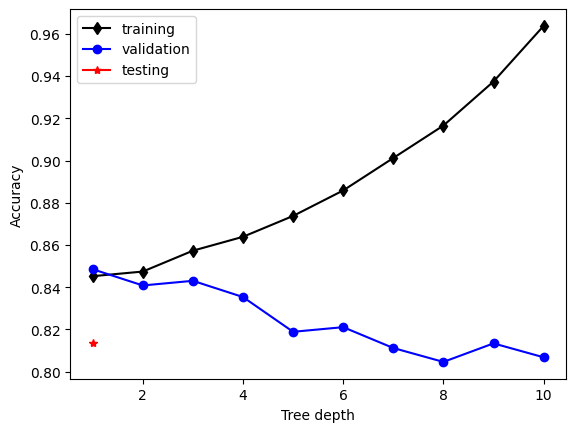

In [ ]:
model_choices=[]
train_acc = []
valid_acc = []

n_train = y_train_tr.shape[0]
n_valid = y_train_va.shape[0]

for k in range(1, 11):
    dt = DecisionTree(max_depth=k, cost_fn=cost_gini_index) # create a KNN object (OOP)

    y_train_tr_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_tr)
    y_train_tr_pred = np.argmax(y_train_tr_prob, axis=-1)
    acc_tr = np.sum(y_train_tr_pred == y_train_tr)/n_train

    y_train_va_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_va)
    y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
    acc_va = np.sum(y_train_va_pred == y_train_va)/n_valid

    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)

# use the best K to predict test data
best_depth = model_choices[valid_acc.index(max(valid_acc))]
dt = DecisionTree(max_depth=best_depth)
y_test_prob = dt.fit(x_train, y_train).predict(x_test)
y_test_pred = np.argmax(y_test_prob, axis=-1)
test_accuracy_dt = np.sum(y_test_pred == y_test)/y_test.shape[0]
print(f'best depth (Gini Index cost function) = {best_depth}, test accuracy = {test_accuracy_dt}')

# plot accuracy for each level of tree depth tested
plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy_dt, marker='*', color='red', label='testing')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('iris_DT_chooseDepth.png',dpi=300,bbox_inches='tight')

It is interesting to note that both the DT with both Entropy and Gini Index as cost functions, the best depth is 1, both with 79.8% accuracy.

**Describe how you obtain the key features used in KNN**

The following function computes the Point-Biserial Correlation Coefficient between a given numerical variable and a categorical variable. This coefficient ranges from -1 to +1, where -1 indicates a perfect negative association, +1 indicates a perfect positive association and 0 indicates no association, similar to other correlation metrics between 2 numerical variables. We used it because

In [ ]:
def biserial_corr(data, Y):

  corrs = {}
  vars = list(data.columns)
  vars.remove(Y)

  binary_0 = data[Y].unique()[0]
  binary_1 = data[Y].unique()[1]

  for var in vars:

    x1 = data.loc[data[Y]== binary_0, var].mean()
    x2 = data.loc[data[Y]== binary_1, var].mean()
    p = (data.loc[data[Y]== binary_0, var].count())/data.shape[0]
    q = 1-p

    s = data[var].std()

    biserial_corr = ((x2-x1)*((p*q)**(1/2)))/s
    corrs[var] = biserial_corr

  return corrs

In [ ]:
biserial_corr(data.iloc[:, 1:], 'age_group')

{'RIDAGEYR': 0.6843393257384399,
 'RIAGENDR': -0.002766484240300737,
 'PAQ605': 0.09476794124666377,
 'BMXBMI': -0.0041459640666527365,
 'LBXGLU': 0.11643621426969462,
 'DIQ010': 0.02639330326298343,
 'LBXGLT': 0.2430593769696516,
 'LBXIN': -0.06414529777732496}

Based on the computed correlation coefficients, the variables which are most strongly associated with either the Adult or Senior age group are "RIDAGEYR" (the respondent's age) and "LBXGLT" (the respondent's oral). As these coefficients are all negative, this suggests both are negatively correlated with the Adult group (binarized as 0). This result is consistent with our earlier analysis of the difference between group means. It is unsuprising that the higher respondent's age, the less likely they are to be classified as an Adult versus a Senior.

**For DT, compute a rough feature importance score for each feature**

In [ ]:
def calc_importance(x_train, y_train, best_depth, cost_fn):
    tree = DecisionTree(max_depth=best_depth, cost_fn=cost_fn)

    tree.fit(x_train, y_train)

    split_features = tree.get_features_used()

    features_used = {}

    for feature in split_features:
        features_used[feature] = split_features.count(feature)

    return features_used

In [ ]:
# We will calculate feature importance scores for the 3 cost functions and the associated optimal tree depths
cost_fns = [cost_misclassification, cost_entropy, cost_gini_index]
cost_names = ['Misclassification', 'Entropy', 'Gini Index']
best_depths = [6, 1, 1]

for i in range(len(cost_fns)):
  features_used = calc_importance(x_train, y_train, best_depths[i], cost_fns[i])
  print(f"Feature Importance Score for tree depth {best_depths[i]} and cost function: {cost_names[i]}")
  for feature_number, importance_score in features_used.items():
      print(f"Feature {feature_number} - {data.columns[3+feature_number]} : Importance Score = {importance_score}")

Feature Importance Score for tree depth 6 and cost function: Misclassification
Feature 2 - BMXBMI : Importance Score = 15
Feature 0 - RIAGENDR : Importance Score = 8
Feature 1 - PAQ605 : Importance Score = 2
Feature 3 - LBXGLU : Importance Score = 7
Feature 5 - LBXGLT : Importance Score = 1
Feature Importance Score for tree depth 1 and cost function: Entropy
Feature 5 - LBXGLT : Importance Score = 1
Feature Importance Score for tree depth 1 and cost function: Gini Index
Feature 5 - LBXGLT : Importance Score = 1


**Extra Experiments**

Use cross-validation to find accuracy scores. The following methodology is from the Model Evaluation and Selection Colab notebook.

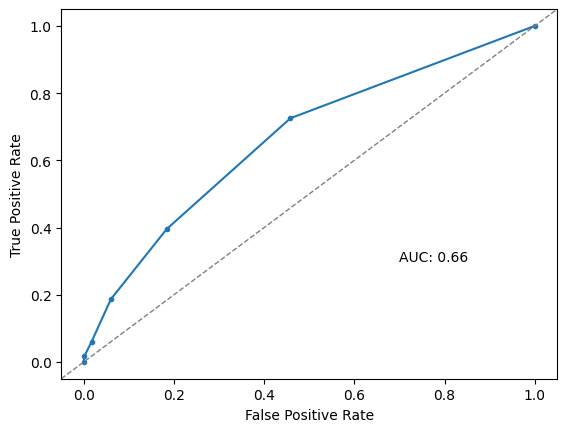

In [ ]:
from sklearn.model_selection import KFold

# manual implementation of K-fold cross-validation
def cross_validate(model, X_input, Y_output):
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    y = np.array([0] * X_input.shape[0])
    yh = np.array([0.0] * X_input.shape[0])
    for train_index, test_index in kf.split(X_input):
        model.fit(X_input[train_index], Y_output[train_index])
        y[test_index] = Y_output[test_index]
        yh[test_index] = model.predict_proba(X_input[test_index])[:,1]
    return y, yh

# create KNN object
knn = KNeighborsClassifier()

true_labels,pred_scores = cross_validate(knn, x, y)

fpr, tpr, _ = roc_curve(true_labels, pred_scores)
auc = roc_auc_score(true_labels, pred_scores)

fig = plt.figure()
ax = fig.add_subplot(111)

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.axline((0, 0), (1, 1), linestyle="--", lw=1, color='gray')
plt.text(0.7, 0.3, 'AUC: '+str(round(auc,2)))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('prostate_cancer_knn_crossvalid_roc.eps')

# **Dataset 2: Breast Cancer Wisconsin dataset**

# Task 1: Acquire, preprocess, and analyze the data

**Explore the data**

Note: class labels are 2 = benign, 4 = malignant.

In [ ]:
# fetch dataset 2: Breast Cancer Wisconsin (Original) dataset
ds_2 = fetch_ucirepo(id=15)

print('Data Table:\n')
data2 = ds_2['data']['original']

check_null = ds_2.data.features

# check for null values
print(f"There are null values: {check_null.isnull().values.any()}")

Data Table:

There are null values: True


In [ ]:
# find where the null values are
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Sample_code_number           699 non-null    int64  
 1   Clump_thickness              699 non-null    int64  
 2   Uniformity_of_cell_size      699 non-null    int64  
 3   Uniformity_of_cell_shape     699 non-null    int64  
 4   Marginal_adhesion            699 non-null    int64  
 5   Single_epithelial_cell_size  699 non-null    int64  
 6   Bare_nuclei                  683 non-null    float64
 7   Bland_chromatin              699 non-null    int64  
 8   Normal_nucleoli              699 non-null    int64  
 9   Mitoses                      699 non-null    int64  
 10  Class                        699 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 60.2 KB


We see that all of the data is numerical, but there are values missing from the Bare_nuclei feature. Since this is not time-series data, where dropping values would be a detriment to our analysis as opposed to imputing values based on averages, for example, we can proceed by dropping the null values from our data.

In [ ]:
print(f'Number of rows of data before cleaning: {len(data2)}\n')

# drop null values
data2.dropna(inplace=True)

print(f'Number of rows of data after cleaning (16 entries removed): {len(data2)}')

Number of rows of data before cleaning: 699

Number of rows of data after cleaning (16 entries removed): 683


In [ ]:
# examine values of data
data2.head()

,Sample_code_number,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [ ]:
# split features and target
x = data2.iloc[:, 1:-1].values #covers all 9 features, excluding the class label

# 2 Converted to 0- 'Benign', 4 converted to 1 - 'Malignant'
y = data2['Class'].factorize()[0]

In [ ]:
# explore statistical properties of data
data2.describe()

,Sample_code_number,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses,Class
count,6.830000e+02,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,1.076720e+06,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,6.206440e+05,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,6.337500e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.776170e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171795e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238705e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [ ]:
# print the feature shape and classes of dataset
(N,D), C = x.shape, np.unique(y).size
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

instances (N) 	 683 
 features (D) 	 9 
 classes (C) 	 2


In [ ]:
# compute the group means
group_means = data2.groupby('Class').mean()
group_means

,Sample_code_number,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses
Class,,,,,,,,,,
2,1.115261e+06,2.963964,1.306306,1.414414,1.346847,2.108108,1.346847,2.083333,1.261261,1.065315
4,1.005121e+06,7.188285,6.577406,6.560669,5.585774,5.326360,7.627615,5.974895,5.857741,2.602510


In [ ]:
# compute and sort the differences in group means
group_diff = (group_means.iloc[0]-group_means.iloc[1])**2
group_diff.sort_values(ascending=False)

Sample_code_number             1.213072e+10
Bare_nuclei                    3.944805e+01
Uniformity_of_cell_size        2.778449e+01
Uniformity_of_cell_shape       2.648394e+01
Normal_nucleoli                2.112762e+01
Marginal_adhesion              1.796850e+01
Clump_thickness                1.784488e+01
Bland_chromatin                1.514426e+01
Single_epithelial_cell_size    1.035714e+01
Mitoses                        2.362969e+00
dtype: float64

<Axes: xlabel='Bare_nuclei', ylabel='Uniformity_of_cell_size'>

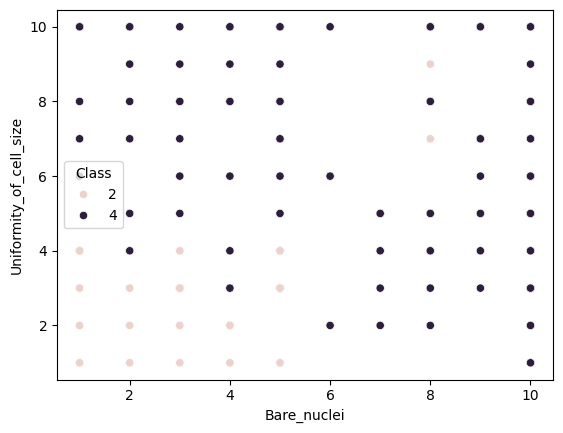

In [ ]:
# visualize this data: plot highest correlated to class (aside from the sequence number feature)
sns.scatterplot(x=data2['Bare_nuclei'],y=data2['Uniformity_of_cell_size'], hue=data2['Class'])

<Axes: xlabel='Bare_nuclei', ylabel='Uniformity_of_cell_shape'>

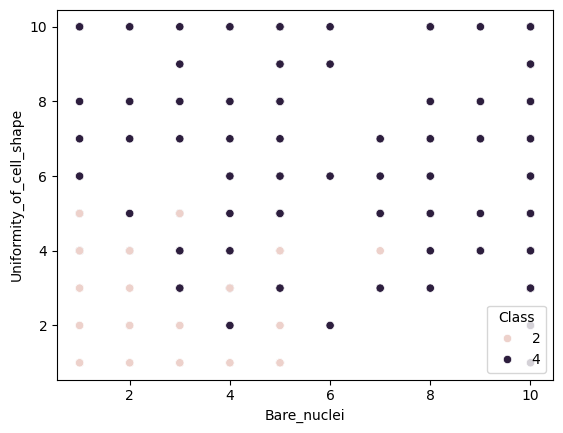

In [ ]:
# plot age versus Respondent's Blood Glucose after fasting
sns.scatterplot(x=data2['Bare_nuclei'],y=data2['Uniformity_of_cell_shape'], hue=data2['Class'])

We see that the above visualization is less helpful than for dataset 1.

We now perform the train/test split for the subsequent classification methods.

In [ ]:
# generate an indices array from 0 to N-1 and permute it
inds = np.random.permutation(N)

np.random.seed(100)
# split the dataset into train and test
# want 80% train and 20% to test. Given N can find index to split on:
index_split = int(N*0.8)
x_train, y_train = x[inds[:index_split]], y[inds[:index_split]]
x_test, y_test = x[inds[index_split:]], y[inds[index_split:]]

**Normalizing the data**

Data should be normalized after splitting it into training and test sets. According to DataCamp, this "is to prevent ‘data leakage’ as the normalization would give the model additional information about the test set if we normalized all the data at once".

In [ ]:
# normalize the data: scale the features using StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

We now examine the data after it has been scaled.

# Task 2: Implementing KNN and DT


The KNN and DT classes are already defined above in the analysis for dataset 1. We proceed with the same analysis for dataset 2.

# Task 3: Running experiments

**Test different K values and see how it affects the training data accuracy and test data accuracy of KNN**

best K = 5, test accuracy = 0.948905109489051


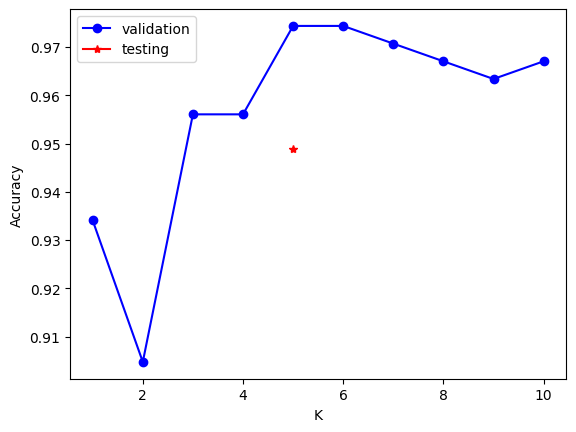

In [ ]:
# further split the training data into 50% training and 50% validation
split_num = int(0.5*x_train.shape[0])
x_train_tr, y_train_tr = x_train[:split_num], y_train[:split_num]
x_train_va, y_train_va = x_train[split_num:], y_train[split_num:]

model_choices=[]
valid_acc = []

n_valid = y_train_va.shape[0]

for k in range(1,11):
    knn = KNN(K=k) # create a KNN object (OOP)
    # y_train_va_prob,_ = knn.fit(x_train, y_train).predict(x_train_va) # wrong
    y_train_va_prob_knn,_ = knn.fit(x_train_tr, y_train_tr).predict_knn(x_train_va) # bug fixed
    y_train_va_pred_knn = np.argmax(y_train_va_prob_knn,axis=-1)
    accuracy = evaluate_acc(y_train_va ,y_train_va_pred_knn)
    model_choices.append(k)
    valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
knn = KNN(K=best_valid_K)
y_test_prob_knn,_ = knn.fit(x_train, y_train).predict_knn(x_test)
y_test_pred_knn = np.argmax(y_test_prob_knn, axis=-1)
test_accuracy_knn = evaluate_acc(y_test, y_test_pred_knn)
#test_accuracy_knn = np.sum(y_test_pred == y_test)/y_test.shape[0]
print(f'best K = {best_valid_K}, test accuracy = {test_accuracy_knn}')

# plot accuracy for each value of K tested
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy_knn, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('iris_KNN_chooseK.png',dpi=300,bbox_inches='tight')

**Test how maximum tree depth affects the performance of DT**

best depth (Misclassification cost function) = 3, test accuracy = 0.9562043795620438


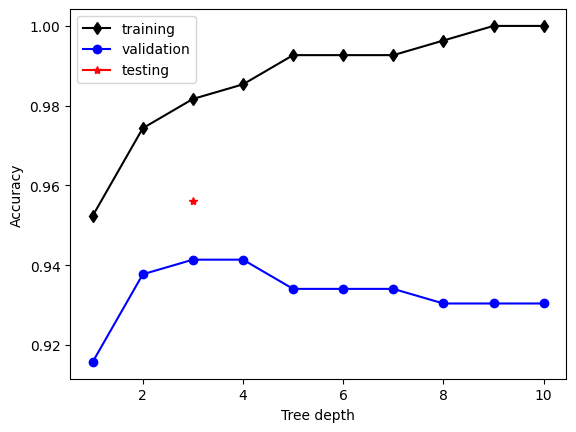

In [ ]:
model_choices=[]
train_acc = []
valid_acc = []

n_train = y_train_tr.shape[0]
n_valid = y_train_va.shape[0]

for k in range(1, 11):
  # create a DecisionTree object (OOP)
  dt = DecisionTree(max_depth=k)

  y_train_tr_prob_dt = dt.fit(x_train_tr, y_train_tr).predict(x_train_tr)
  y_train_tr_pred_dt = np.argmax(y_train_tr_prob_dt, axis=-1)
  acc_tr = evaluate_acc(y_train_tr, y_train_tr_pred_dt)

  y_train_va_prob_dt = dt.fit(x_train_tr, y_train_tr).predict(x_train_va)
  y_train_va_pred_dt = np.argmax(y_train_va_prob_dt, axis=-1)
  acc_va = evaluate_acc(y_train_va, y_train_va_pred_dt)

  model_choices.append(k)
  train_acc.append(acc_tr)
  valid_acc.append(acc_va)

# use the best K to predict test data
best_depth = model_choices[valid_acc.index(max(valid_acc))]
dt = DecisionTree(max_depth=best_depth)
y_test_prob_dt = dt.fit(x_train, y_train).predict(x_test)
y_test_pred_dt = np.argmax(y_test_prob_dt, axis=-1)
test_accuracy_dt = evaluate_acc(y_test, y_test_pred_dt)
print(f'best depth (Misclassification cost function) = {best_depth}, test accuracy = {test_accuracy_dt}')

# plot accuracy for each level of tree depth tested
plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy_dt, marker='*', color='red', label='testing')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('iris_DT_chooseDepth.png',dpi=300,bbox_inches='tight')

**Compare the accuracy and AUROC of KNN and DT algorithm**

In [ ]:
# define a function evaluate_acc to evaluate the model accuracy
def evaluate_acc(y_test_actual, y_test_pred):
  accuracy = np.sum(y_test_pred == y_test_actual)/y_test_actual.shape[0]
  return accuracy

In [ ]:
compare_models = {'Model': ['KNN', 'Decision Tree'], 'Test Accuracy (with K = 4, Max Depth = 2)': [test_accuracy_knn, test_accuracy_dt]}

pd.DataFrame(compare_models)

,Model,"Test Accuracy (with K = 4, Max Depth = 2)"
0,KNN,0.948905
1,Decision Tree,0.956204


**Plot the ROC for KNN and DT**

True/False Positive Rates for KNN

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_knn)

cm_df_knn = pd.DataFrame(cm, index=['Actual Negative','Actual Positive'],
                     columns=['Predicted Negative', 'Predicted Positive'])
print(cm_df_knn)

                 Predicted Negative  Predicted Positive
Actual Negative                  86                   4
Actual Positive                   3                  44


True/False Positive Rates for DT

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_dt)

cm_df_dt = pd.DataFrame(cm, index=['Actual Negative','Actual Positive'],
                     columns=['Predicted Negative', 'Predicted Positive'])
print(cm_df_dt)

                 Predicted Negative  Predicted Positive
Actual Negative                  87                   3
Actual Positive                   3                  44


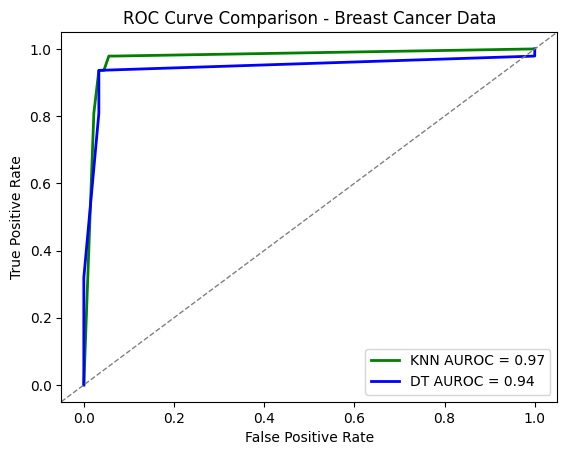

In [ ]:
# Calculating ROC curve values and AUC score
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_test_prob_knn[:, 1])
roc_auc_knn = roc_auc_score(y_test, y_test_prob_knn[:, 1])

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_test_prob_dt[:, 1])
roc_auc_dt = roc_auc_score(y_test, y_test_prob_dt[:, 1])

plt.clf()
plt.plot(fpr_knn, tpr_knn, "g-", lw=2, label="KNN AUROC = %0.2f" % roc_auc_knn)
plt.plot(fpr_dt, tpr_dt, "b-", lw=2, label="DT AUROC = %0.2f" % roc_auc_dt)
plt.axline((0, 0), (1, 1), linestyle="--", lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - Breast Cancer Data')
plt.legend(loc="best")
plt.savefig("roc_curve.png", bbox_inches='tight', dpi=300)

**Test different distance/cost functions**

Try KNN with Manhattan distance function, since we're working with continuous input features

best K (Manhattan Distance) = 7, test accuracy = 0.948905109489051


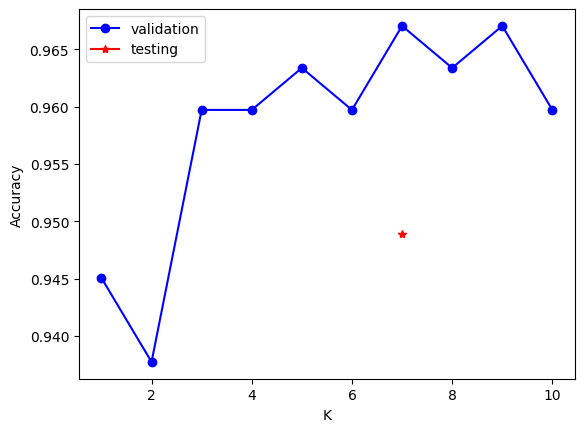

In [ ]:
split_num = int(0.5*x_train.shape[0])
x_train_tr, y_train_tr = x_train[:split_num], y_train[:split_num]
x_train_va, y_train_va = x_train[split_num:], y_train[split_num:]

model_choices=[]
valid_acc = []

n_valid = y_train_va.shape[0]

for k in range(1,11):
  # create a KNN object (OOP)
  knn = KNN(K=k, dist_fn = manhattan)
  # y_train_va_prob,_ = knn.fit(x_train, y_train).predict(x_train_va) # wrong
  y_train_va_prob,_ = knn.fit(x_train_tr, y_train_tr).predict_knn(x_train_va) # bug fixed
  y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)
  accuracy = np.sum(y_train_va_pred == y_train_va)/n_valid
  model_choices.append(k)
  valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
knn = KNN(K=best_valid_K)
y_test_prob,_ = knn.fit(x_train, y_train).predict_knn(x_test)
y_test_pred = np.argmax(y_test_prob, axis=-1)
test_accuracy_knn = np.sum(y_test_pred == y_test)/y_test.shape[0]
print(f'best K (Manhattan Distance) = {best_valid_K}, test accuracy = {test_accuracy_knn}')

# plot accuracy for each value of K tested
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy_knn, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('iris_KNN_chooseK.png',dpi=300,bbox_inches='tight')

Try Decision Tree with Entropy as cost function

best depth (Entropy cost function) = 3, test accuracy = 0.9562043795620438


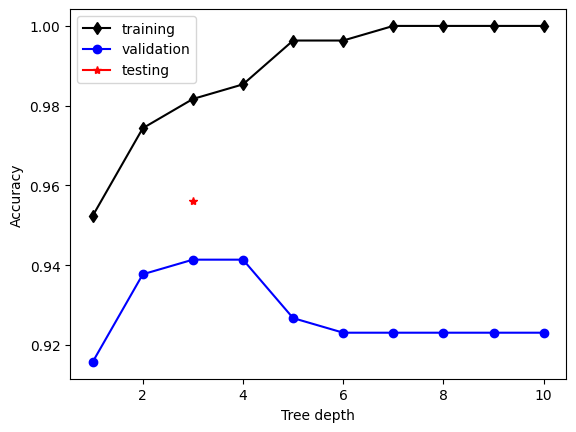

In [ ]:
model_choices=[]
train_acc = []
valid_acc = []

n_train = y_train_tr.shape[0]
n_valid = y_train_va.shape[0]

for k in range(1, 11):
    dt = DecisionTree(max_depth=k, cost_fn=cost_entropy) # create a KNN object (OOP)

    y_train_tr_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_tr)
    y_train_tr_pred = np.argmax(y_train_tr_prob, axis=-1)
    acc_tr = np.sum(y_train_tr_pred == y_train_tr)/n_train

    y_train_va_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_va)
    y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
    acc_va = np.sum(y_train_va_pred == y_train_va)/n_valid

    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)

# use the best K to predict test data
best_depth = model_choices[valid_acc.index(max(valid_acc))]
dt = DecisionTree(max_depth=best_depth)
y_test_prob = dt.fit(x_train, y_train).predict(x_test)
y_test_pred = np.argmax(y_test_prob, axis=-1)
test_accuracy_dt = np.sum(y_test_pred == y_test)/y_test.shape[0]
print(f'best depth (Entropy cost function) = {best_depth}, test accuracy = {test_accuracy_dt}')

# plot accuracy for each level of tree depth tested
plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy_dt, marker='*', color='red', label='testing')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('iris_DT_chooseDepth.png',dpi=300,bbox_inches='tight')

Try Decision Tree with Gini Index as cost function

best depth (Gini Index cost function) = 3, test accuracy = 0.9562043795620438


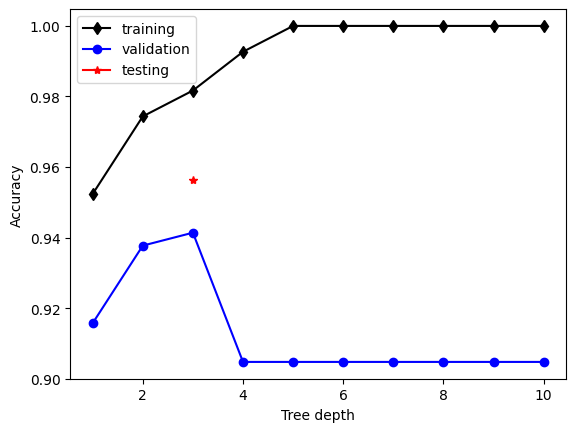

In [ ]:
model_choices=[]
train_acc = []
valid_acc = []

n_train = y_train_tr.shape[0]
n_valid = y_train_va.shape[0]

for k in range(1, 11):
    dt = DecisionTree(max_depth=k, cost_fn=cost_gini_index) # create a KNN object (OOP)

    y_train_tr_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_tr)
    y_train_tr_pred = np.argmax(y_train_tr_prob, axis=-1)
    acc_tr = np.sum(y_train_tr_pred == y_train_tr)/n_train

    y_train_va_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_va)
    y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
    acc_va = np.sum(y_train_va_pred == y_train_va)/n_valid

    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)

# use the best K to predict test data
best_depth = model_choices[valid_acc.index(max(valid_acc))]
dt = DecisionTree(max_depth=best_depth)
y_test_prob = dt.fit(x_train, y_train).predict(x_test)
y_test_pred = np.argmax(y_test_prob, axis=-1)
test_accuracy_dt = np.sum(y_test_pred == y_test)/y_test.shape[0]
print(f'best depth (Gini Index cost function) = {best_depth}, test accuracy = {test_accuracy_dt}')

# plot accuracy for each level of tree depth tested
plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy_dt, marker='*', color='red', label='testing')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('iris_DT_chooseDepth.png',dpi=300,bbox_inches='tight')

**Describe how you obtain the key features used in KNN**

Here we used the same Point-Biserial Correlation Coefficient as previously.

In [ ]:
biserial_corr(data2.iloc[:, 1:], 'Class')

{'Clump_thickness': 0.7142664623732805,
 'Uniformity_of_cell_size': 0.8202003431899061,
 'Uniformity_of_cell_shape': 0.8212890501729939,
 'Marginal_adhesion': 0.7057768932616177,
 'Single_epithelial_cell_size': 0.6904521479179591,
 'Bare_nuclei': 0.8220933860075629,
 'Bland_chromatin': 0.7576722797943376,
 'Normal_nucleoli': 0.7181508771584842,
 'Mitoses': 0.4231378165877125}

Based on the computed correlation coefficients, the variables which are most strongly associated with either the Benign or Malignant group are "Bare_nuclei", "Uniformity_of_cell_size" and "Uniformity_of_cell_size". As these coefficients are all negative, this suggests both are negatively correlated with the Benign group. This result is consistent with our earlier analysis of the difference between group means. These variables had the largest difference between groups.

**For DT, compute a rough feature importance score for each feature**

In [ ]:
#We will calculate feature importance scores for the 3 cost functions and the associated
#optimal tree depths
cost_fns = [cost_misclassification, cost_entropy, cost_gini_index]
cost_names = ['Misclassification', 'Entropy', 'Gini Index']
best_depths = [3, 3, 3]

for i in range(len(cost_fns)):
  features_used = calc_importance(x_train, y_train, best_depths[i], cost_fns[i])
  print(f"\nFeature Importance Score for tree depth {best_depths[i]} and cost function: {cost_names[i]}")
  for feature_number, importance_score in features_used.items():
      print(f"Feature {feature_number} - {data2.columns[1+feature_number]} : Importance Score = {importance_score}")


Feature Importance Score for tree depth 3 and cost function: Misclassification
Feature 1 - Uniformity_of_cell_size : Importance Score = 2
Feature 5 - Bare_nuclei : Importance Score = 1
Feature 7 - Normal_nucleoli : Importance Score = 1
Feature 0 - Clump_thickness : Importance Score = 2
Feature 2 - Uniformity_of_cell_shape : Importance Score = 1

Feature Importance Score for tree depth 3 and cost function: Entropy
Feature 1 - Uniformity_of_cell_size : Importance Score = 2
Feature 0 - Clump_thickness : Importance Score = 1
Feature 5 - Bare_nuclei : Importance Score = 2
Feature 6 - Bland_chromatin : Importance Score = 2

Feature Importance Score for tree depth 3 and cost function: Gini Index
Feature 1 - Uniformity_of_cell_size : Importance Score = 2
Feature 5 - Bare_nuclei : Importance Score = 2
Feature 7 - Normal_nucleoli : Importance Score = 1
Feature 2 - Uniformity_of_cell_shape : Importance Score = 1
Feature 3 - Marginal_adhesion : Importance Score = 1


**Extra Experiments**

Future area of exploration includes implementing K-fold cross-validation with our own implementation of the KNN class.

Text(0, 0.5, 'True Positive Rate')

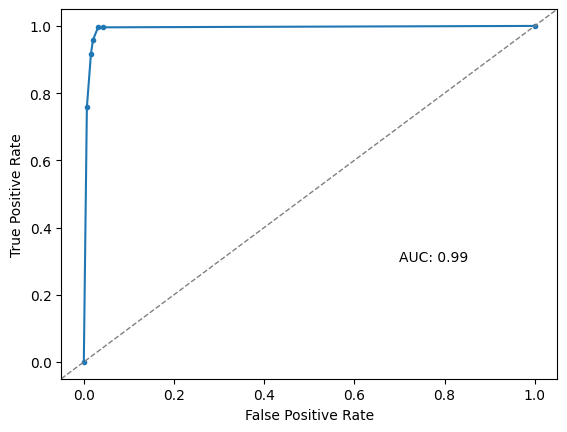

In [ ]:
from sklearn.model_selection import KFold

# manual implementation of K-fold cross-validation
def cross_validate(model, X_input, Y_output):
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    y = np.array([0] * X_input.shape[0])
    yh = np.array([0.0] * X_input.shape[0])
    for train_index, test_index in kf.split(X_input):
        model.fit(X_input[train_index], Y_output[train_index])
        y[test_index] = Y_output[test_index]
        yh[test_index] = model.predict_proba(X_input[test_index])[:,1]
    return y, yh

# create KNN object
knn = KNeighborsClassifier()

true_labels,pred_scores = cross_validate(knn, x, y)

fpr, tpr, _ = roc_curve(true_labels, pred_scores)
auc = roc_auc_score(true_labels, pred_scores)

fig = plt.figure()
ax = fig.add_subplot(111)

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.axline((0, 0), (1, 1), linestyle="--", lw=1, color='gray')
plt.text(0.7, 0.3, 'AUC: '+str(round(auc,2)))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")